### 1. 자전거 대여 수요예측 실습

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

bike_df=pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
bike_df.info() #datetime은 string

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
bike_df['datetime']=bike_df.datetime.apply(pd.to_datetime)

bike_df['year']=bike_df.datetime.apply(lambda x:x.year)
bike_df['month']=bike_df.datetime.apply(lambda x:x.month)
bike_df['day']=bike_df.datetime.apply(lambda x:x.day)
bike_df['hour']=bike_df.datetime.apply(lambda x:x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [7]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
 15  hour        10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [8]:
drop_columns=['datetime','casual','registered']
bike_df.drop(drop_columns,axis=1,inplace=True)

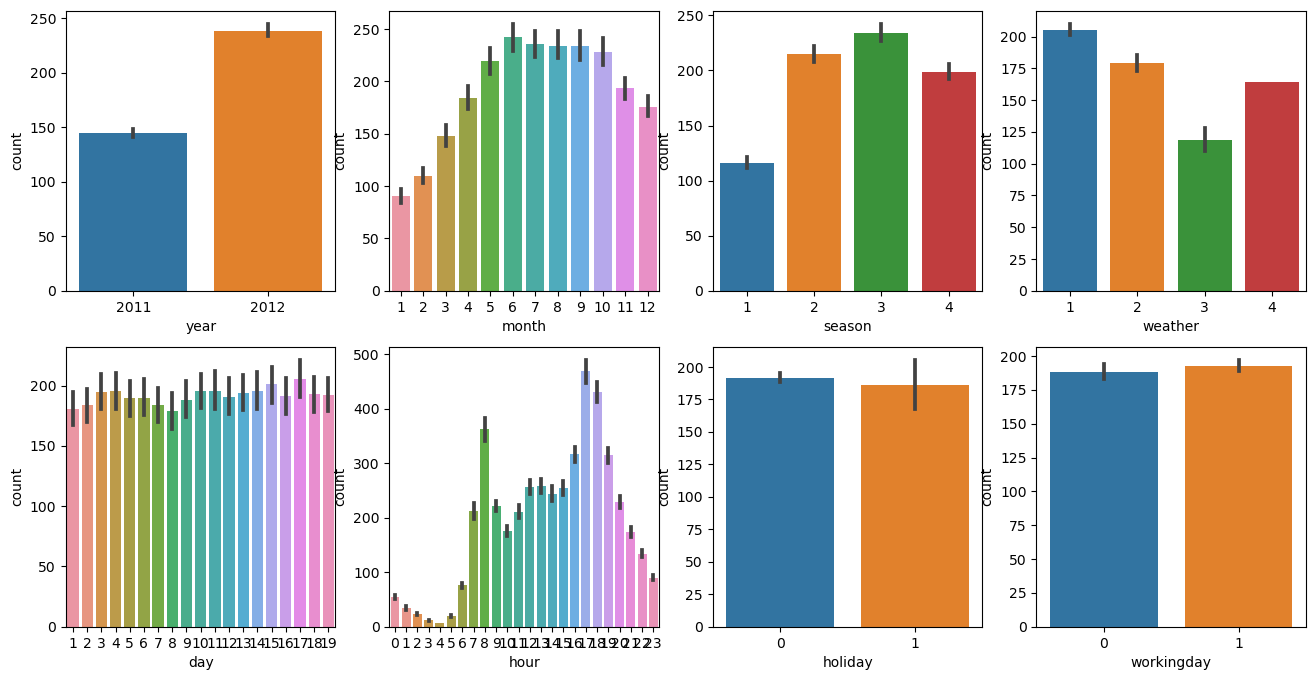

In [11]:
fig,axs=plt.subplots(figsize=[16,8],ncols=4, nrows=2)
cat_features=['year','month','season','weather','day','hour','holiday','workingday']

for i, feature in enumerate(cat_features):
    row=int(i/4)
    col=i%4
    sns.barplot(x=feature, y='count',data=bike_df,ax=axs[row][col])

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)#0이 되지 않게 하려고.
    squared_error=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('RMSLE:{0:.3f}. RMSE:{1:.3f},MAE:{2:.3f}'.format(rmsle_val, rmse_val,mae_val))

In [16]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target=bike_df['count']
X_features=bike_df.drop(['count'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features,y_target,test_size=0.3,random_state=0)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE:1.165. RMSE:140.900,MAE:105.924


In [24]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df=pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count']=np.round(pred)
    result_df['diff']=np.abs(result_df['real_count']-result_df['predicted_count'])
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

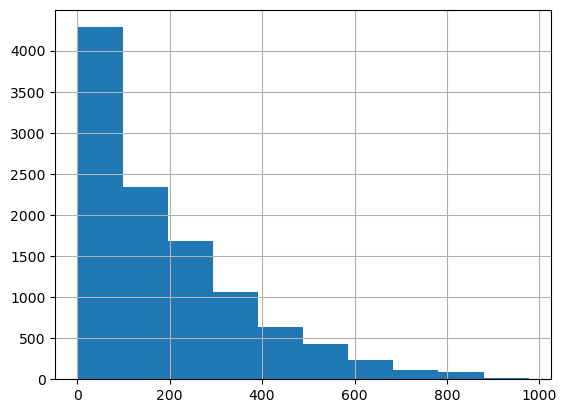

In [25]:
y_target.hist()

<Axes: >

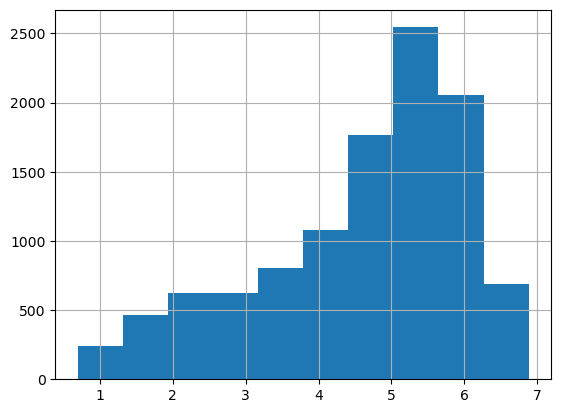

In [26]:
y_log_transform=np.log1p(y_target)
y_log_transform.hist()

In [29]:
y_target_log=np.log1p(y_target)

X_train, X_test, y_train, y_test=train_test_split(X_features,y_target_log,test_size=0.3,random_state=0)
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)
pred=lr_reg.predict(X_test)#예측값이 로그 변환된 값이므로 값이 모두 작다.

#다시 변환시켜주어야함
y_test_exp=np.expm1(y_test)

pred_exp=np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE:1.017. RMSE:162.594,MAE:109.286


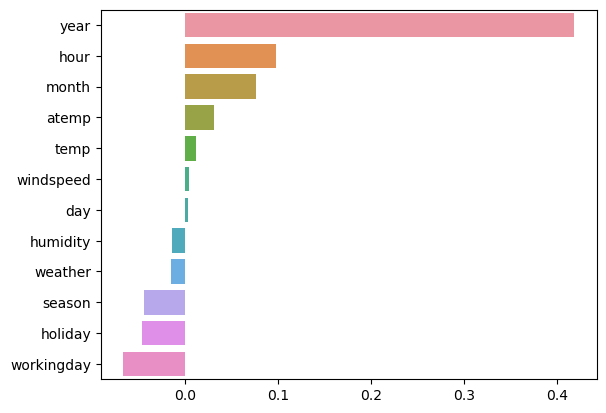

In [31]:
coef=pd.Series(lr_reg.coef_,index=X_features.columns)
coef_sort=coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif',format='tif',dpi=300,bbox_inches='tight')

In [33]:
X_features_ohe=pd.get_dummies(X_features, columns=['year','month','day','hour','holiday','workingday',
                                                   'season','weather'])

In [36]:
X_train, X_test, y_train, y_test=train_test_split(X_features_ohe,
                                                  y_target_log,test_size=0.3,random_state=0)

def get_model_predict(model, X_train,X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if is_expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test,pred)

lr_reg=LinearRegression()
ridge_reg=Ridge(alpha=10)
lasso_reg=Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model,X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE:0.590. RMSE:97.690,MAE:63.383
### Ridge ###
RMSLE:0.590. RMSE:98.529,MAE:63.893
### Lasso ###
RMSLE:0.635. RMSE:113.219,MAE:72.803


<Axes: >

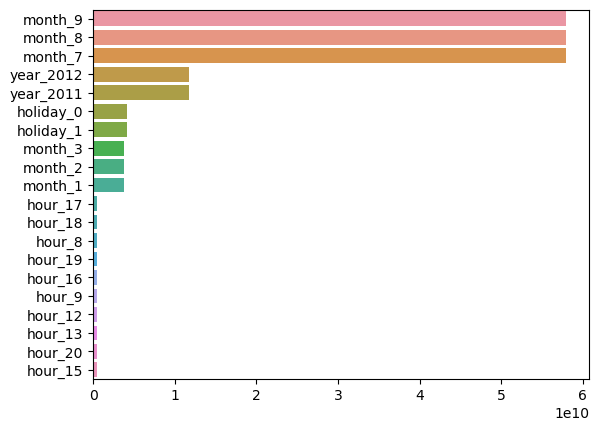

In [37]:
coef=pd.Series(lr_reg.coef_,index=X_features_ohe.columns)
coef_sort=coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 2. 캐글 주택 사격예측 실습

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

house_df_org=pd.read_csv('./house_price.csv')#원본
house_df=house_df_org.copy()
bike_df.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,0
1,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,2


In [39]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [56]:
house_df.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

C:\Users\a0103\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


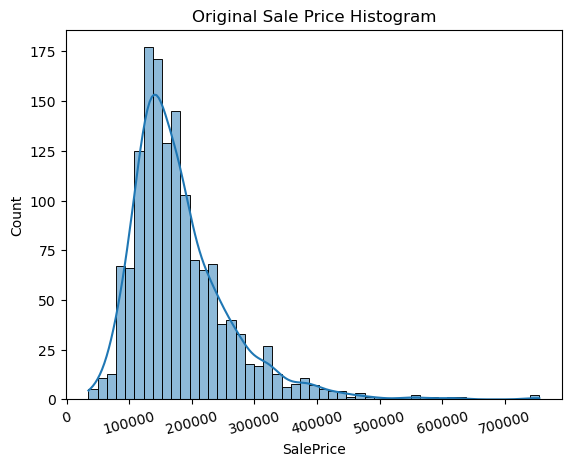

In [57]:
#타겟값의 분포를 확인해야한다.
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'],kde=True)
plt.show()

C:\Users\a0103\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


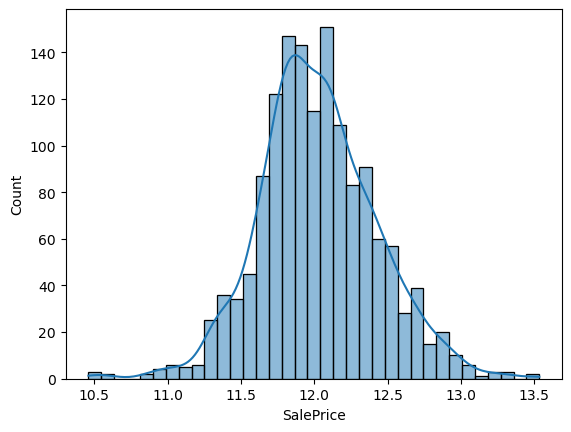

In [58]:
#로그 변환
log_SalePrice=np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice,kde=True)
plt.show()

In [59]:
original_SalePrice=house_df['SalePrice']
house_df['SalePrice']=np.log1p(house_df['SalePrice'])

house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis=1, inplace=True)
# house_df.fillna(house_df.mean(), inplace=True)
# 숫자형 데이터만 선택해서 평균 계산
numeric_cols_mean = house_df.select_dtypes(include=[np.number]).mean()

# 해당 평균으로 결측값 채우기
house_df.fillna(numeric_cols_mean, inplace=True)


null_column_count=house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type :\n',house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [63]:
#get_dummies는 null값도 인코딩한다.
print(house_df.shape)
house_df_ohe=pd.get_dummies(house_df)
print(house_df_ohe.shape)
null_column_count=house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print(house_df_ohe.dtypes[null_column_count.index])

(1460, 75)
(1460, 270)
Series([], dtype: object)


In [72]:
def get_rmse(model):
    pred=model.predict(X_test)
    #y_test, pred는 로그 스캐일임
    mse=mean_squared_error(y_test, pred)
    rmse=np.sqrt(mse)
    print('{0}로그 변환된 RMSE:{1}'.format(model.__class__.__name__,np.round(rmse,3)))
    return rmse

def get_rmses(models):
    rmses=[]
    for model in models:
        rmse=get_rmse(model)
        rmses.append(rmse)
    return rmses

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error

y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop(['SalePrice'],axis=1,inplace=False)

X_train, X_test, y_train, y_test=train_test_split(X_features,y_target,test_size=0.2,random_state=156)

lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg=Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg=Lasso()
lasso_reg.fit(X_train, y_train)

models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)


LinearRegression로그 변환된 RMSE:0.132
Ridge로그 변환된 RMSE:0.127
Lasso로그 변환된 RMSE:0.176


[0.13183184688250138, 0.1274058283626617, 0.17628250556471395]

In [80]:
#5폴드 교차검증으로 모델별 RMSE와 평균RMSE출력

from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list=np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error',cv=5))
        rmse_avg=np.mean(rmse_list)
        print('\n{0}cv RMSE값 리스트:{1}'.format(model.__class__.__name__,np.round(rmse_list,3)))
        print('{0}cv 평균 RMSE값 :{1}'.format(model.__class__.__name__,np.round(rmse_avg,3)))

models=[ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridgecv RMSE값 리스트:[0.117 0.154 0.142 0.117 0.189]
Ridgecv 평균 RMSE값 :0.144

Lassocv RMSE값 리스트:[0.161 0.204 0.177 0.181 0.265]
Lassocv 평균 RMSE값 :0.198


In [85]:
#하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model=GridSearchCV(model, param_grid=params,scoring='neg_mean_squared_error',cv=5)
    grid_model.fit(X_features, y_target)
    rmse=np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__
                                                             ,np.round(rmse,4),grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05, 0.03, 0.1,0.5,1.5, 10]}
best_ridge=print_best_params(ridge_reg, ridge_params)
best_lasso=print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


In [87]:
lr_reg=LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg=Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg=Ridge(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models=[lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

models=[lr_reg, ridge_reg, lasso_reg]

LinearRegression로그 변환된 RMSE:0.132
Ridge로그 변환된 RMSE:0.124
Ridge로그 변환된 RMSE:0.132


In [90]:
from scipy.stats import skew

features_index=house_df.dtypes[house_df.dtypes!='object'].index

skew_features=house_df[features_index].apply(lambda x:skew(x))
skew_features_top=skew_features[skew_features>1]#1이상인 것들만 뽑아낸다.
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [92]:
house_df[skew_features_top.index]=np.log1p(house_df[skew_features_top.index])

In [94]:
house_df_ohe=pd.get_dummies(house_df)
y_target=house_df_ohe['SalePrice']
X_features=house_df_ohe.drop('SalePrice',axis=1,inplace=False)
X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params={'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params={'alpha':[0.001,0.005,0.008,0.05, 0.03, 0.1,0.5,1.5, 10]}
best_ridge=print_best_params(ridge_reg, ridge_params)
best_lasso=print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
